# Lecture 14: Class demo

## Let's cluster images!!

![](../img/eva-fun-times.png)

For this demo, I'm going to use two image datasets: 
1. A small subset of [200 Bird Species with 11,788 Images](https://www.kaggle.com/datasets/veeralakrishna/200-bird-species-with-11788-images) (available [here](https://github.ubc.ca/mds-2021-22/datasets/blob/master/data/birds.zip))
2. A tiny subset of [Food-101](https://www.kaggle.com/datasets/kmader/food41?select=food_c101_n10099_r32x32x1.h5)
(available [here](https://github.ubc.ca/mds-2021-22/datasets/blob/master/data/food.zip))


To run the code below, you need to install pytorch and torchvision in the course conda environment. 

```conda install pytorch torchvision -c pytorch```

In [59]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt

In [60]:
import torchvision

Let's start with  small subset of birds dataset. You can experiment with a bigger dataset if you like.

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [62]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [63]:
set_seed(seed=42)

In [64]:
import glob
IMAGE_SIZE = 200
def read_img_dataset(data_dir):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [65]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [66]:
data_dir = "data/birds"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
birds_inputs, birds_classes = read_img_dataset(data_dir)

In [67]:
X_birds = birds_inputs.numpy()

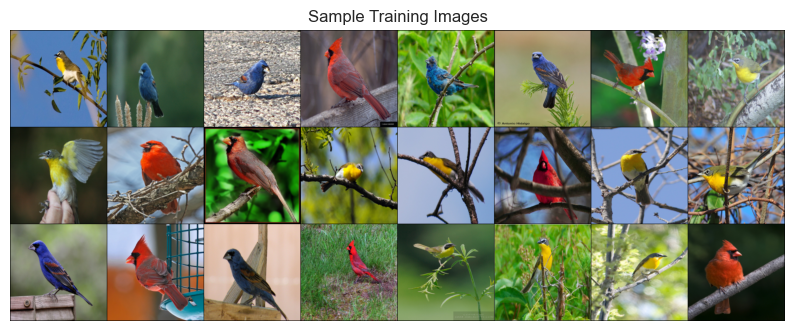

In [68]:
plot_sample_imgs(birds_inputs[0:24,:,:,:])

For clustering we need to calculate distances between points. So we need a vector representation for each data point. A simplest way to create a vector representation of an image is by flattening the image.  

In [69]:
flatten_transforms = transforms.Compose([
                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),    
                    transforms.Lambda(torch.flatten)])
flatten_images = datasets.ImageFolder(root='./data/birds', transform=flatten_transforms)

In [70]:
flatten_dataloader = torch.utils.data.DataLoader(
        flatten_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )

In [71]:
flatten_train, y_train = next(iter(flatten_dataloader))

In [72]:
flatten_images = flatten_train.numpy()

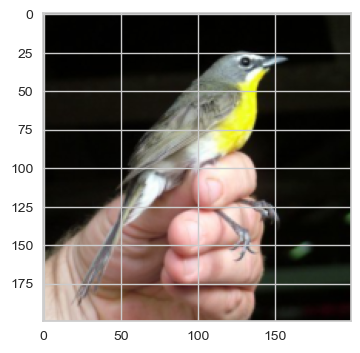

In [73]:
image_shape=[3,200,200]
img = flatten_images[20].reshape(image_shape)
plt.imshow(np.transpose(img / 2 + 0.5, (1, 2, 0)));

In [74]:
flatten_images.shape # 200 by 200 images with 3 color channels

(176, 120000)

In [75]:
k = 3
km_flatten = KMeans(k, n_init='auto', random_state=123)
km_flatten.fit(flatten_images)

KMeans(n_clusters=3, n_init='auto', random_state=123)

In [76]:
km_flatten.cluster_centers_.shape

(3, 120000)

In [77]:
flatten_images.shape

(176, 120000)

In [78]:
unflatten_inputs = np.array([img.reshape(image_shape) for img in flatten_images])

Image indices:  [123 143 114 133  10]


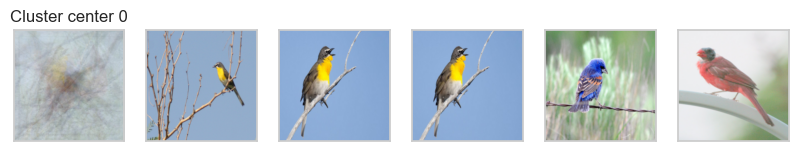

Image indices:  [ 38  48  47 139  91]


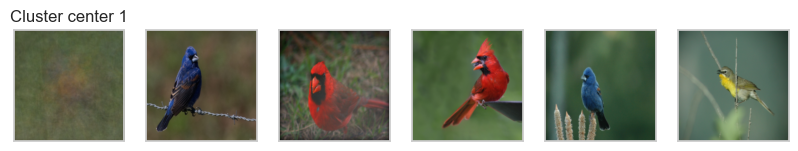

Image indices:  [ 41 103  50  44 162]


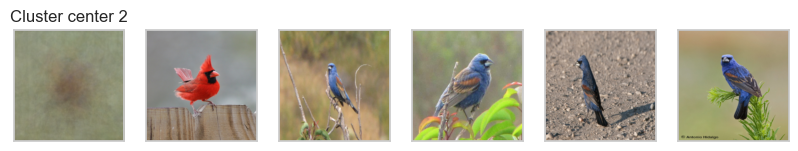

In [79]:
for cluster in range(k):
    get_cluster_images(km_flatten, flatten_images, unflatten_inputs, cluster, n_img=5)

We see some mis-categorizations. How about trying more flexible GMMs? 

In [80]:
from sklearn.mixture import GaussianMixture

gmm_flatten = GaussianMixture(n_components=k,covariance_type='diag', random_state=123)
gmm_flatten.fit(flatten_images)

GaussianMixture(covariance_type='diag', n_components=3, random_state=123)

Image indices:  [ 63  58 106  13 148]


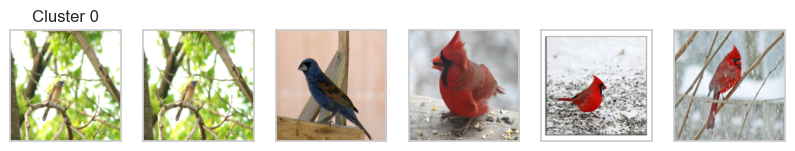

Image indices:  [ 67  65  64  91 175]


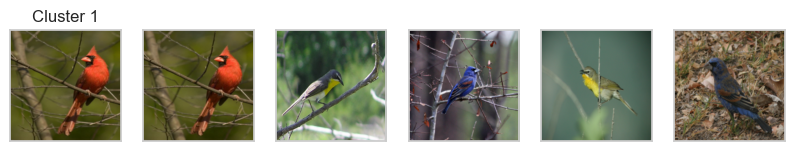

Image indices:  [ 92  35  89 103   0]


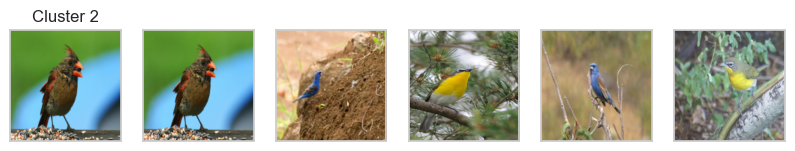

In [81]:
for cluster in range(k):
    get_cluster_images(gmm_flatten, flatten_images, unflatten_inputs, cluster=cluster, n_img=5)

We still see some mis-categorizations. It seems like when we flatten images, clustering doesn't seem that great.  

How about trying out a different input representation? Let's use transfer learning as a feature extractor with a pre-trained vision model. For each image in our dataset we'll pass it through a pretrained network and get a representation from the last layer, before the classification layer given by the pre-trained network. 

![](img/cnn-ex.png)

Source: https://cezannec.github.io/Convolutional_Neural_Networks/

In [82]:
def get_features(model, inputs):
    """Extract output of densenet model"""
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_train = torch.cat((Z_train, model(inputs)), dim=0)
    return Z_train.detach()

In [83]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

In [84]:
Z_birds = get_features(
    densenet, birds_inputs, 
).numpy()

In [85]:
Z_birds.shape

(176, 1024)

Do we get better clustering with this representation? 

In [86]:
from sklearn.cluster import KMeans

k = 3
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_birds)

KMeans(n_clusters=3, n_init='auto', random_state=123)

In [87]:
km.cluster_centers_.shape

(3, 1024)

Image indices:  [109 116  99 112 113 114]


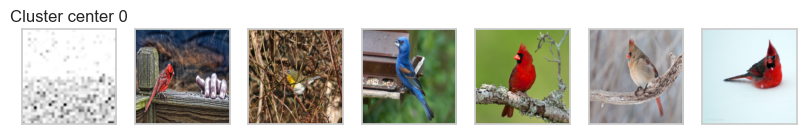

Image indices:  [174 140  47  39 148 108]


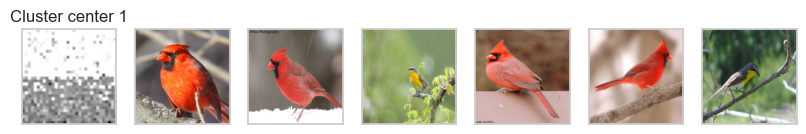

Image indices:  [ 78  16 135 149  24  58]


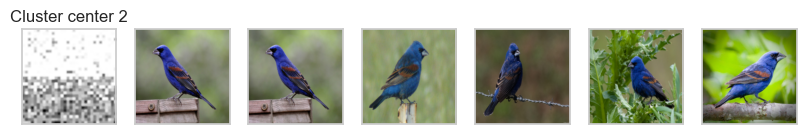

In [88]:
for cluster in range(k):
    get_cluster_images(km, Z_birds, X_birds, cluster, n_img=6)

KMeans seems to be doing a good job. But cluster centers are not interpretable at all now. Let's try GMMs.  

In [89]:
gmm = GaussianMixture(n_components=k, random_state=123)
gmm.fit(Z_birds)

GaussianMixture(n_components=3, random_state=123)

In [90]:
gmm.weights_

array([0.01704545, 0.68181818, 0.30113636])

Image indices:  [ 61  62 175  99 116 109]


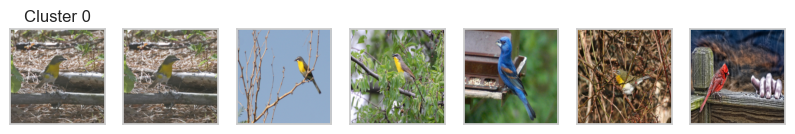

Image indices:  [ 67  71  72  74 102 175]


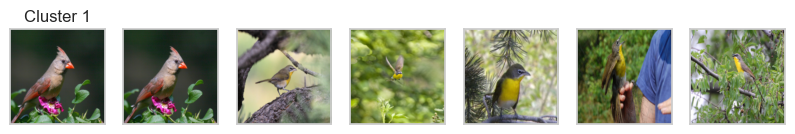

Image indices:  [119 118  34  35  30 124]


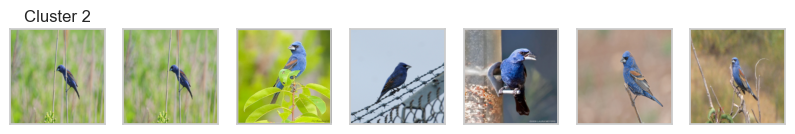

In [91]:
for cluster in range(k):
    get_cluster_images(gmm, Z_birds, X_birds, cluster, n_img=6)

Cool! Both models are doing a great job with this representation!! This dataset seems easier, as the birds have very distinct colors. Let's try a bit more complicated dataset.  

In [92]:
data_dir = "data/food"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
food_inputs, food_classes = read_img_dataset(data_dir)
n_images

350

In [93]:
X_food = food_inputs.numpy()

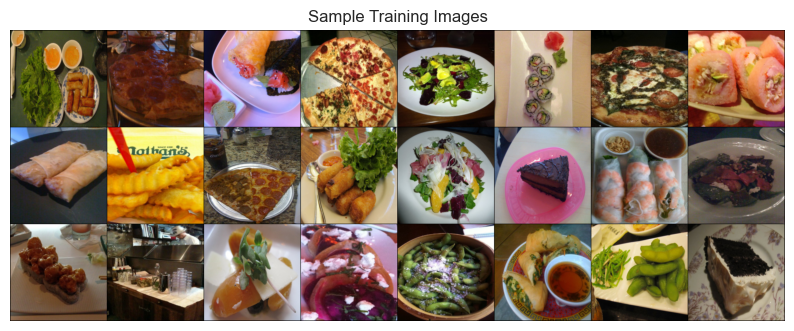

In [94]:
plot_sample_imgs(food_inputs[0:24,:,:,:])

In [95]:
Z_food = get_features(
    densenet, food_inputs, 
).numpy()

In [96]:
Z_food.shape

(350, 1024)

In [97]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_food)

KMeans(n_clusters=5, n_init='auto', random_state=123)

In [98]:
km.cluster_centers_.shape

(5, 1024)

Image indices:  [322   0 237 236 235 234]


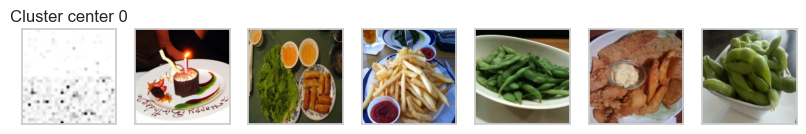

Image indices:  [178 309 334 300 279 201]


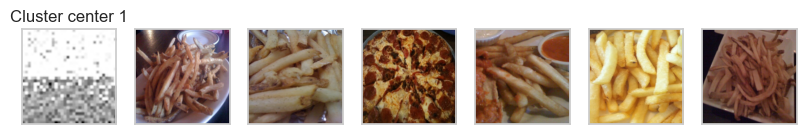

Image indices:  [ 44 204 129  54  19 169]


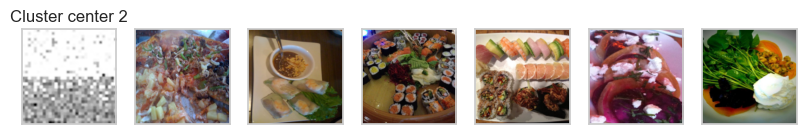

Image indices:  [116  45 286  85 301 206]


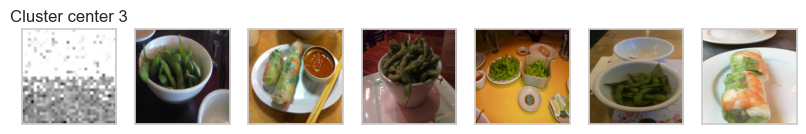

Image indices:  [256 225 255 124 190  13]


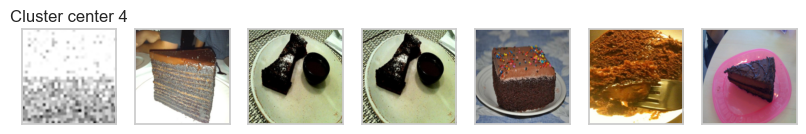

In [99]:
for cluster in range(k):
    get_cluster_images(km, Z_food, X_food, cluster, n_img=6)

There are some mis-classifications but overall it seems pretty good! You can experiment with 
- Different values for number of clusters
- Different pre-trained models
- Other possible representations 
- Different image datasets

See an example of using K-Means clustering on customer segmentation in [AppendixA](./AppendixA.ipynb).